In [16]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

try:
#     os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#     os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    import setGPU
except:
    print('no setGPU')

In [17]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

In [18]:
#random seed 고정
tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 2
NUM_EPOCHS = 3
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [19]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

# 개체명 인식 학습 데이터 개수: 81000
# 개체명 인식 테스트 데이터 개수: 9000

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


In [20]:
# Label 불러오기

def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))

개체명 인식 레이블 개수: 30


In [21]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0
# cls_token_label_id = 1
# sep_token_label_id = 2

I0822 08:36:53.351701 140526050977600 tokenization_utils_base.py:1254] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at bert_ckpt/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729


In [22]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
            
    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [unk_token]
        tokens.extend(word_tokens)
        
        # 슬롯 레이블 값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))
  
    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
    return label_ids

In [23]:
def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
        
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

        ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
        assert len(words) == len(labels_idx)

        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

train_ner_df = train_ner_df[:100]
test_ner_df = test_ner_df[:10]

train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

In [31]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        
        print(sequence_output.size())
        
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        
        print(logits.size())

        return logits

In [26]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

I0822 08:37:35.585758 140526050977600 configuration_utils.py:264] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at bert_ckpt/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
I0822 08:37:35.587702 140526050977600 configuration_utils.py:300] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
 

In [32]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 값을 계산할 때 제외
    
#     print("labels")
#     print(labels)

    active_loss = tf.reshape(labels, (-1,)) != 0
    
#     print("Active loss")
#     print(active_loss)
    
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
    
#     print(reduced_logits)
    
#     print("labels")
#     print(labels)
    
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
    
#     print("labels")
#     print(labels)
    
    return loss_fn(labels, reduced_logits)

# labels
# tf.Tensor(
# [[ 0. 10. 11. 11. 11. 11. 11. 11.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#    1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 10. 11. 11. 11.  1.  1.
#    1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.]
#  [ 0.  1.  1. 28. 29. 29.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.]], shape=(2, 111), dtype=float32)
# Active loss
# tf.Tensor(
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False], shape=(222,), dtype=bool)
# tf.Tensor(
# [[-0.20070355  0.57105565 -0.5764023  ...  0.966773    0.6161363
#    0.20100808]
#  [-0.25403374  1.8692875   0.02586203 ...  1.727051    0.20142289
#    1.2762938 ]
#  [-0.413098    2.3735065   0.05344111 ...  1.8781955  -0.13177925
#    0.5967046 ]
#  ...
#  [-0.27605966  1.8134694  -0.47742274 ...  0.9219384  -0.38688442
#    0.44301265]
#  [ 0.45511377  1.2056724  -0.3297121  ...  0.11512136  0.20294163
#   -0.048159  ]
#  [ 0.40559357  0.8873435  -0.8129963  ...  0.31500405  0.73742664
#   -0.35371864]], shape=(66, 30), dtype=float32)
# labels
# tf.Tensor(
# [[ 0. 10. 11. 11. 11. 11. 11. 11.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#    1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 10. 11. 11. 11.  1.  1.
#    1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.]
#  [ 0.  1.  1. 28. 29. 29.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.]], shape=(2, 111), dtype=float32)
# labels
# tf.Tensor(
# [10. 11. 11. 11. 11. 11. 11.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 10. 11. 11. 11.  1.  1.  1.
#   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 28. 29. 29.
#   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.], shape=(66,), dtype=float32)
#  1/50 [..............................] - ETA: 0s - loss: 3.1371labels
# tf.Tensor(
# [[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#    1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.]
#  [ 0.  2.  3.  3.  3.  3.  3.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#    1. 12. 13. 13. 13.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
#    0.  0.  0.]], shape=(2, 111), dtype=float32)
# Active loss
# tf.Tensor(
# [False  True  True  True  True  True  True  True  True  True  True  True
#   True  True  True  True  True  True  True  True  True False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False  True  True  True  True  True  True  True  True
#   True  True  True  True  True  True  True  True  True  True  True  True
#   True  True  True False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False False False False False False False
#  False False False False False False], shape=(222,), dtype=bool)
# tf.Tensor(
# [[ 0.14271234  1.716831   -0.47607824 ... -0.47392145 -0.02658497
#    0.043262  ]
#  [ 0.13837923  2.4716344  -0.06783289 ...  0.31900546 -0.6919821
#    0.38450852]
#  [-0.16288234  1.9954419   0.5078238  ...  1.2905562  -0.22989689
#    0.7669436 ]
#  ...
#  [-0.6484789   2.6197963   0.50899017 ...  0.25902334  0.3628642
#    0.59585446]
#  [-0.17161797  2.446683    0.1203839  ...  0.29811338  0.03967901
#    0.06480265]
#  [-0.43927494  2.2669454   0.32655752 ...  0.45683378  0.74146104
#    0.5793219 ]], shape=(43, 30), dtype=float32)


# # labels
# # Tensor("Cast:0", shape=(None, 111), dtype=float32)
# # Active loss
# # Tensor("compute_loss/NotEqual:0", shape=(None,), dtype=bool)
# # Tensor("compute_loss/boolean_mask/GatherV2:0", shape=(None, 30), dtype=float32)
# # labels
# # Tensor("Cast:0", shape=(None, 111), dtype=float32)
# # labels
# # Tensor("compute_loss/boolean_mask_1/GatherV2:0", shape=(None,), dtype=float32)

In [33]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def compute_metrics(self, labels, preds):
        assert len(preds) == len(labels)
        return self.f1_pre_rec(labels, preds)

    def f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }


    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)
        
    def on_epoch_end(self, epoch, logs=None):

        results = {}
        
        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)

        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])
                    
        result = self.compute_metrics(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

In [34]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, metrics=[metric], run_eagerly=True)

In [35]:
model_name = "tf2_bert_ner"

# overfitting을 막기 위한 ealrystop 추가
# earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

data_out/KOR/tf2_bert_ner -- Folder already exists 

Epoch 1/3
tf.Tensor(
[[[-0.07443924  0.24800523 -0.02131325 ... -0.0199714   0.15805037
   -0.10380514]
  [-0.40269506 -0.16692697 -0.6325792  ...  0.44971678  0.33717972
   -0.10481893]
  [-0.497388   -0.5864385  -0.7693258  ...  0.03826445 -0.05193064
   -0.16569759]
  ...
  [ 0.25545835 -0.04935126  0.04217207 ...  0.38775048 -0.1972645
   -0.01859268]
  [ 0.22117865  0.12915228 -0.07454002 ...  0.48301572  0.07817091
    0.02605512]
  [ 0.05055051  0.03400309 -0.21688351 ...  0.03196582 -0.16636518
   -0.05076252]]

 [[ 0.07619494 -0.15667984 -1.1669291  ...  0.14204237 -0.15298676
    0.20735177]
  [-0.00499333 -0.26836598 -0.7267086  ...  0.33563086 -0.0110449
    0.35297087]
  [ 0.09242608 -0.1499206  -0.78818    ...  0.4012647  -0.13695817
    0.29675466]
  ...
  [ 0.18306959 -0.03468788 -0.7985733  ...  0.3316649  -0.09468274
    0.05696651]
  [-0.04009705  0.01112057 -1.3552696  ...  0.13506782 -0.20241247
    0.10135588]
 

W0822 08:38:36.101951 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:36.103462 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 1/50 [..............................] - ETA: 0s - loss: 1.1207tf.Tensor(
[[[ 1.2433099e-01 -7.7975050e-02 -8.7228894e-01 ...  2.9896572e-01
    5.0747279e-02  1.4806022e-01]
  [ 2.3503663e-01 -2.9677296e-01 -5.6296504e-01 ...  2.8759035e-01
    1.5319347e-01  1.5158972e-01]
  [ 1.4340948e-01 -2.0895265e-02  3.1281739e-02 ... -2.3118678e-01
   -1.2996504e-01 -2.1462013e-01]
  ...
  [ 2.5344330e-01 -1.5888764e-01 -3.2551700e-01 ... -1.5553352e-01
   -2.0303488e-01  1.1983452e-01]
  [ 1.2221143e-01  2.3326479e-02 -6.4863753e-01 ...  1.3692570e-01
   -4.4130281e-01 -1.3751315e-01]
  [ 3.2931414e-01  5.8767468e-02 -6.8074214e-01 ... -7.5803675e-02
   -1.2960769e-03  2.2174536e-01]]

 [[-3.2329053e-02 -1.6198739e-02 -1.3751152e-01 ...  3.8511220e-01
    1.3018037e-01  2.1118240e-01]
  [-1.4711693e-01 -3.0221438e-01 -1.2786909e+00 ...  1.7345372e-01
    1.2048785e-01  2.4047685e-01]
  [ 1.8165800e-01 -4.2444348e-01 -1.1135237e+00 ...  1.0356566e-01
   -1.5180463e-01 -6.8312734e-03]
  ...
  [

W0822 08:38:36.699764 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:36.701286 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 2/50 [>.............................] - ETA: 7s - loss: 0.9253tf.Tensor(
[[[ 0.12091741  0.17787883 -0.43745708 ... -0.0335957  -0.00658043
    0.00756799]
  [ 0.4036661   0.7750824  -0.15617588 ...  0.1775846  -0.11455399
    0.17278141]
  [ 0.6079567  -0.01935063 -0.09362912 ...  0.32765418  0.19244489
   -0.31727928]
  ...
  [ 0.15666397  0.5032347   0.10561304 ...  0.55810255 -0.29337856
    0.11589751]
  [ 0.19561337 -0.03576734 -0.12526375 ... -0.08428595 -0.13879427
    0.15857942]
  [-0.17123826 -0.12344179 -0.37702712 ...  0.20981991  0.29825002
    0.15912986]]

 [[ 0.37964484  0.14706509 -0.3431179  ...  0.18491584  0.06459381
    0.47014284]
  [ 0.46691167  0.01011347 -0.08948401 ...  0.02671723  0.23768239
    0.77586895]
  [ 0.44910833  0.12127022 -0.24817225 ...  0.28868687 -0.18004084
    0.5645289 ]
  ...
  [ 0.4933225   0.21431433 -0.26231366 ...  0.3692086  -0.24651214
    0.521429  ]
  [ 0.6138916   0.23157576  0.02333641 ...  0.5712595  -0.15962455
    0.35604328]

W0822 08:38:37.002016 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:37.003476 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 3/50 [>.............................] - ETA: 9s - loss: 1.1558tf.Tensor(
[[[-0.02707453  0.06339432 -0.56469893 ...  0.03701512  0.08968805
    0.20232914]
  [-0.04994207 -0.42812756 -0.01025918 ...  0.4916075   0.6061877
    0.05110875]
  [ 0.12784986  0.5087373   0.31001046 ...  0.97569996  0.54126143
    0.13998207]
  ...
  [ 0.51093185  0.56613946  0.17436771 ...  0.16432735  0.3963673
    0.23925334]
  [ 0.63094753  0.22842896  0.21835116 ...  0.17427029  0.30135334
    0.41589427]
  [ 0.42667115  0.11130663  0.09016742 ...  0.47373444  0.2229301
    0.24694125]]

 [[-0.00949082  0.10907927 -0.940733   ...  0.31956345  0.28005192
    0.22155473]
  [-0.19209684 -0.3788687  -0.6552747  ...  0.6530351   0.5068382
    0.7096187 ]
  [ 0.16956048 -0.18899417 -0.5099542  ...  0.52477276  0.20355262
    0.453044  ]
  ...
  [ 0.3402422  -0.1487709  -0.7788224  ...  0.9287153   0.30703717
    0.23326425]
  [ 0.03400918 -0.06527546 -0.78922296 ...  0.8367818   0.04295072
    0.27087426]
  [

W0822 08:38:37.314431 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:37.315898 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 4/50 [=>............................] - ETA: 10s - loss: 1.2817tf.Tensor(
[[[ 0.3267191   0.14357321 -0.82271945 ...  0.7726398   0.2080428
    0.3104596 ]
  [ 0.52326024 -0.2843689  -0.5089729  ...  0.3716668   0.10364316
    0.19255194]
  [ 0.40628317  0.1462273  -0.4734526  ...  0.5229182  -0.05199898
    0.15592836]
  ...
  [ 0.31033573 -0.12839115 -0.07337862 ...  0.43199635 -0.21864232
    0.57176566]
  [ 0.15042514 -0.0025755  -0.11571005 ...  0.3200792  -0.09418477
    0.7860855 ]
  [ 0.12858813  0.21609117 -0.00346324 ...  0.8145499  -0.23722735
    0.5047684 ]]

 [[-0.02458411  0.26347607 -0.26619214 ...  0.11196942  0.22109278
    0.0917889 ]
  [ 0.2446397   0.04127125 -0.9598513  ... -0.34811267  0.33601546
    0.14397004]
  [ 0.14141208  0.24700567 -0.08236915 ... -0.31920528  0.42760202
   -0.09140822]
  ...
  [-0.30127826  0.0126216  -0.44530612 ...  0.08870154 -0.16299501
   -0.15924475]
  [ 0.02708641  0.03611124 -0.33671454 ...  0.9743847   0.3216643
   -0.00601815]


W0822 08:38:37.635703 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:37.637937 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 5/50 [==>...........................] - ETA: 11s - loss: 1.1986tf.Tensor(
[[[ 0.10430133  0.08953271 -0.36675438 ...  0.36195415  0.16151658
    0.03467861]
  [-0.22250359 -0.3334303  -0.80111074 ...  0.60524184  0.59272903
   -0.1554309 ]
  [ 0.976337    0.0633807   0.01543781 ...  0.63673663  0.65947944
   -0.3896357 ]
  ...
  [ 0.08846288 -0.11462159 -0.8323675  ...  0.40718377  0.51345605
    0.24673524]
  [ 0.48533046  0.28254837 -0.5335032  ...  0.21943712  0.0316106
    0.13011573]
  [ 0.15112737 -0.14165305  0.2846888  ...  0.50318706  0.00391639
    0.51422495]]

 [[ 0.19942394  0.36768076 -0.18706805 ...  0.19749644  0.19219911
    0.37459272]
  [-0.1871873   0.1449609  -0.40619254 ...  0.3212599   0.91593945
    0.8187309 ]
  [ 0.67335755 -0.18037121 -0.53261936 ...  0.00159602  0.6870138
    0.3984916 ]
  ...
  [ 0.26276544 -0.20111339 -0.04112053 ... -0.04102193  0.1472848
    0.4153378 ]
  [ 0.05014079 -0.49471655  0.29945728 ...  0.2927215   0.34448525
    0.80324   ]
 

W0822 08:38:38.066971 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:38.068750 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 6/50 [==>...........................] - ETA: 12s - loss: 1.2403tf.Tensor(
[[[ 0.0185107   0.3889622  -0.90924495 ...  0.4308744   0.18360311
    0.26380712]
  [ 0.04947934  0.22802344 -0.41288665 ...  0.5102527   0.38827685
   -0.02004535]
  [ 0.30114484  0.48366743 -0.23604447 ...  0.40030938  0.80857426
    0.23987871]
  ...
  [ 0.55859244  0.07379024 -1.7390381  ...  0.66867167  0.08954856
   -0.01739896]
  [ 0.45154303  0.3540746  -1.2207863  ...  0.9016598   0.08297215
    0.11864657]
  [ 0.3816815   0.26794776 -0.7741056  ...  1.0555059   0.28972927
    0.22472909]]

 [[ 0.06001178  0.17913108 -0.53430355 ...  0.13458829  0.06300414
   -0.01657979]
  [-0.22918057 -0.11195509 -1.1912218  ...  1.0497248   0.12951425
   -0.235225  ]
  [-0.25526807  0.27632245 -0.55515814 ...  0.58491206  0.17313346
    0.09845532]
  ...
  [-0.24985282  0.25449523  0.12112086 ...  0.22525874  0.27900767
   -0.10822768]
  [-0.22846209  0.17193292 -0.21680933 ...  1.0149875   0.06215579
   -0.65306187

W0822 08:38:38.417980 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:38.419396 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 7/50 [===>..........................] - ETA: 12s - loss: 1.1446tf.Tensor(
[[[ 0.11343397 -0.02315342 -0.46622023 ...  0.3244945   0.08992109
   -0.1698819 ]
  [ 0.32477835  0.01557674  0.43695667 ...  1.1285846   0.2564889
   -0.10824956]
  [ 0.65005344 -0.34906167 -0.8641666  ...  0.568784    0.47370696
    0.5693648 ]
  ...
  [ 0.36599222  0.35931492  0.36387917 ...  0.3405664   0.04133314
    0.228023  ]
  [ 0.16987498  0.04460997 -0.32145387 ...  0.4660999   0.3392039
   -0.00184212]
  [ 0.08654428 -0.27981713 -0.02508104 ... -0.09371141  0.41647476
   -0.11086178]]

 [[-0.05341849  0.16199756 -0.22979787 ...  0.32295966  0.16490777
    0.24773757]
  [-0.05786699 -0.44303626  0.05435705 ...  0.4607816   0.6478481
   -0.0626742 ]
  [-0.28960603 -0.21889846  0.22224608 ... -0.01408732  0.4532699
    0.4594182 ]
  ...
  [-0.14953092  0.20191702 -0.16509467 ...  0.11751957  0.3551899
    0.16068244]
  [-0.01214106  0.20305565  0.46310782 ...  0.742031    0.31815985
    0.8197392 ]
  [

W0822 08:38:38.757402 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:38.758815 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 8/50 [===>..........................] - ETA: 12s - loss: 1.2479tf.Tensor(
[[[ 0.34739223 -0.14923362 -0.85922635 ...  0.45530286  0.0777873
    0.5357335 ]
  [-0.07961209 -0.4552495  -0.8265435  ...  1.1469226   0.16127267
    0.32571083]
  [ 0.44099864 -0.1630134  -0.06860355 ...  1.1524965  -0.27471188
    0.5355999 ]
  ...
  [ 0.79702616  0.08112405 -0.28102565 ...  0.391427    0.07707265
    0.9570103 ]
  [ 0.26381958 -0.22962746 -0.01012871 ...  0.62295514 -0.07096347
    0.93980694]
  [ 0.18563415  0.02854487 -0.0435186  ...  0.60955864 -0.02772327
    0.8537201 ]]

 [[ 0.22908048 -0.07369515 -0.66198236 ...  0.2728032   0.5413142
    0.13058582]
  [ 0.43294933  0.02254111  0.22324285 ...  0.11194739  0.66540414
    0.46246877]
  [-0.05990149  0.06746811 -0.8555517  ...  0.40206838  0.23128802
    0.34885585]
  ...
  [ 0.25552353  0.38460535  0.5162239  ...  0.28634763  0.7450752
    0.13682637]
  [ 0.31793374  0.08416631 -0.11229461 ...  0.40723842  0.5278444
    0.4242002 ]
  

W0822 08:38:39.101481 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:39.102923 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


 9/50 [====>.........................] - ETA: 12s - loss: 1.2952tf.Tensor(
[[[ 0.23810631 -0.00514393 -0.63531935 ...  0.53126824  0.4878931
    0.2712312 ]
  [-0.2927592  -0.06507796 -0.36047226 ...  0.97162503  0.5572517
    0.031409  ]
  [ 0.7194402   0.5215344   0.48527172 ...  0.4919303   0.4783795
    0.24834782]
  ...
  [ 0.48780724  0.19788003 -0.8921285  ...  0.53957945  0.04769599
    0.17067164]
  [ 0.5432632   0.275411   -0.38775614 ...  0.19232783  0.20082694
    0.5871106 ]
  [ 0.8355129   0.31545335 -0.44046172 ...  0.46982342  0.4151628
    0.7169848 ]]

 [[ 0.25806057 -0.01967619 -0.7187487  ...  0.2733629   0.05540989
    0.44150645]
  [-0.09747179 -0.2748967   1.1574316  ...  0.9228022  -0.42241073
    0.9964894 ]
  [ 0.03608075 -0.37683398  0.27040383 ...  0.50252056 -0.3650557
    1.2947664 ]
  ...
  [ 0.44657737  0.02533473 -0.62067556 ...  0.67933077  0.14718759
    0.16517329]
  [ 0.69704926  0.1993094   0.17596363 ...  0.89743745  0.34098592
    0.4159341 ]
  [

W0822 08:38:39.452291 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:39.453831 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


10/50 [=====>........................] - ETA: 12s - loss: 1.4091tf.Tensor(
[[[ 0.14637022  0.11426764 -0.58043724 ...  0.32282007  0.0956039
   -0.03762397]
  [-0.355387   -0.23371993  0.08454908 ... -0.6091751   0.8522158
    0.36043906]
  [ 0.32995397 -0.11021504 -0.5337098  ...  0.51247615  0.3950597
   -0.24171361]
  ...
  [-0.0100745  -0.06881858 -0.00922298 ...  0.5479399   0.02510991
    0.71182525]
  [ 0.1637453   0.24770087 -0.29225442 ...  0.58248305 -0.04511673
    0.5653794 ]
  [ 0.5533381  -0.13427424  0.524014   ...  0.19804762  0.5235097
   -0.06741232]]

 [[-0.10869975 -0.11473026 -0.4014783  ...  0.19623154  0.17908317
   -0.12221663]
  [ 0.00463295 -0.09600793  0.11226116 ...  1.3416728   0.17502931
    0.17969324]
  [-0.2741377  -0.31022155 -0.48043177 ...  0.84808314  0.35110024
    0.6015091 ]
  ...
  [-0.31598574 -0.00844481  0.07380147 ...  1.0447005   0.4188996
   -0.46366173]
  [-0.27479127 -0.12177087  0.29607353 ...  1.5798637   0.39347693
   -0.09640031]
  [

W0822 08:38:39.767447 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:39.769222 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


11/50 [=====>........................] - ETA: 11s - loss: 1.3938tf.Tensor(
[[[ 0.22503552  0.02869108 -0.47576174 ...  0.26698315  0.05816631
    0.47592607]
  [ 0.50278187  0.3645808  -0.03345862 ...  0.4885324   0.62683946
    0.51966405]
  [ 0.5435878   0.06249581  0.27029616 ...  0.03713716  0.3589834
    0.6142628 ]
  ...
  [ 0.4353009   0.362906   -0.12274846 ...  0.2578777   0.29406738
    0.2948125 ]
  [ 0.30620205  0.08706452 -0.07132545 ...  0.5048328  -0.04627674
    0.775682  ]
  [ 0.6571654   0.40081507 -0.15986934 ...  0.6192552   0.2502951
    0.73608404]]

 [[ 0.4065083   0.00788276 -0.5628518  ...  0.1794493  -0.14144695
    0.5947923 ]
  [ 0.7081712  -0.16910428 -0.66282946 ...  0.18093449  0.08200198
    0.38397858]
  [ 0.6226412   0.3943358  -0.03934196 ...  0.26119226 -0.01595322
    0.6202468 ]
  ...
  [ 1.1942414   0.52835804 -0.6417072  ...  0.2965353   0.12168935
    0.58344406]
  [ 0.8709417   0.12215406 -0.62033296 ... -0.3639409  -0.40216777
    0.48331946]


W0822 08:38:40.110121 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:40.111548 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


12/50 [======>.......................] - ETA: 11s - loss: 1.4283tf.Tensor(
[[[ 0.20618625  0.263678   -0.329118   ...  0.5004324   0.34752792
    0.10614784]
  [ 0.7758904   0.23542318  0.00202459 ...  0.8103794   0.36781797
   -0.10286154]
  [ 0.34542477 -0.15128578  0.5866106  ...  0.45643926  0.3260874
   -0.14645526]
  ...
  [ 0.64632565 -0.09533376 -0.5887666  ...  0.492011    0.36903742
   -0.2647433 ]
  [ 0.75722796  0.26851255 -0.05915526 ...  0.2112911   0.21634953
   -0.01682971]
  [ 0.73034847  0.31994992 -0.20539477 ...  0.24824984  0.17408268
    0.06458435]]

 [[ 0.18882455  0.25457817 -0.3733333  ...  0.03626493  0.13848476
   -0.03957519]
  [-0.20696777  0.04879305 -0.35135135 ...  1.2526258  -0.09867741
   -0.17153645]
  [ 0.4134841   0.01936951 -0.34480697 ...  0.5586119  -0.1669768
   -0.57447183]
  ...
  [ 0.8805199   0.81405985  0.3859915  ... -0.14498408 -0.6875605
    0.19211254]
  [ 1.2575729   0.3274331   0.5102316  ... -0.21385393 -0.58263695
    0.37356445]
 

W0822 08:38:40.450340 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:40.451770 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


13/50 [======>.......................] - ETA: 11s - loss: 1.4361tf.Tensor(
[[[ 0.20348324  0.09003997 -0.930439   ...  0.91893566  0.4512742
    0.13375393]
  [ 0.21788627 -0.45955908 -1.4475348  ...  1.3143643   0.12985313
    0.04505189]
  [-0.11048105  0.07325123 -1.2648622  ...  1.0945327   0.04375407
    0.43634963]
  ...
  [ 0.44672975  0.61512345 -0.5734541  ...  0.6499382   0.36412406
    0.5149528 ]
  [ 0.4033171   0.64902997 -0.71786714 ...  0.07785157  0.200354
    0.37429833]
  [ 0.51627344  0.5373708  -0.19976199 ...  0.52322865  0.2904312
    0.32049662]]

 [[ 0.00900133  0.11375403 -0.6202717  ...  0.02191635  0.11806437
    0.19583905]
  [-0.10500726  0.26883924 -0.5899325  ...  0.86554503  0.4976061
   -0.0277999 ]
  [-0.5786891  -0.17487606  0.48063684 ...  0.02243353  0.8249189
   -0.38208848]
  ...
  [-0.06689796  0.07202585 -0.40001163 ...  0.6824783   0.14820777
    0.2046926 ]
  [ 0.24412946  0.6347864  -0.3147557  ...  0.1947681   0.2752711
    0.806351  ]
  [-0

W0822 08:38:40.790529 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:40.791965 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


14/50 [=======>......................] - ETA: 11s - loss: 1.4480tf.Tensor(
[[[ 0.2062209   0.2658833  -0.4755956  ...  0.17655873 -0.03328959
    0.15790492]
  [ 0.55436593 -0.4492835  -0.04917553 ...  0.35957995  0.45906806
   -0.13254476]
  [ 0.965685   -0.00721733  0.25907335 ...  0.2040354   0.29571474
   -0.03505889]
  ...
  [ 0.5185468   0.32156378  0.41273618 ...  0.08716479  0.61108136
    0.1936462 ]
  [ 0.31219417  0.6110807   0.403148   ...  0.15541968  0.2122947
    0.21912396]
  [ 0.19724376  0.4058522  -0.15204963 ...  0.24897523  0.50864613
    0.4344828 ]]

 [[ 0.0876306   0.10883363 -0.41463402 ...  0.10815148  0.14845963
   -0.17800012]
  [ 0.2163989  -0.02456857  0.17200491 ...  0.43255737  0.14176878
    0.20627555]
  [ 0.15533474 -0.035001   -0.8629497  ...  0.97618234  0.6683568
   -0.5186572 ]
  ...
  [ 0.16123027  0.01371838 -0.41986597 ...  0.83426803  0.1821723
    0.6046205 ]
  [ 0.0120465  -0.05326521  0.4539233  ...  0.5851621   0.34489375
    0.20643938]
 

W0822 08:38:41.130949 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.
W0822 08:38:41.132388 140526050977600 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss.


KeyboardInterrupt: 

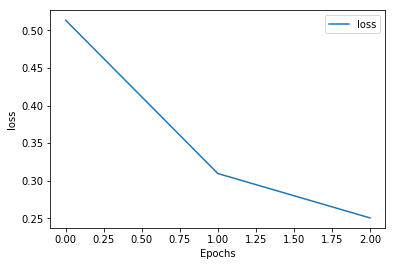

In [34]:
plot_graphs(history, 'loss')

In [17]:
# https://towardsdatascience.com/how-to-compute-f1-score-for-named-entity-recognition-in-keras-6f28b31dccca